<a href="https://colab.research.google.com/github/gaixen/BCS_recruitment/blob/main/The%20Goblet%20of%20Fire/Gymnasium_demo_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [80]:
!pip install pygame
!pip install gymnasium

In [81]:
from collections import defaultdict
import gymnasium as gym
import numpy as np

# Setting up the enviroment

In [82]:
class BlackjackAgent:
  def __init__(
      #initialising the enviroment variables like lr,epsilon_decay,discoun_factor etc
      self,
      env:gym.Env,
      learning_rate:float,
      initial_epsilon:float,
      epsilon_decay_rate:float,
      final_epsilon:float,
      discount_factor:float=0.95,
):
      self.env=env
      self.q_values=defaultdict(lambda:np.zeros(env.action_space.n))
      self.lr=learning_rate
      self.discount_factor=discount_factor
      self.epsilon=initial_epsilon
      self.epsilon_decay_rate=epsilon_decay_rate
      self.final_epsilon=final_epsilon
      self.training_error=[]

  def get_action(self,obs:tuple[float,float,bool])->float:

  #getting for the best possible option with probability 1-epsilon
     if np.random.random()<self.epsilon:

      return self.env.action_space.sample()
  #else trying posiibility with probability epsilon
     else:

      return float(np.argmax(self.q_values[obs]))

  def update(
    self,
    obs:tuple[float,float,bool],
    action:float,
    reward:float,
    terminated:bool,
    next_obs:tuple[float,float,bool],
):
    future_q_values=(not terminated)*np.max(self.q_values[next_obs])
    temporal_difference=(reward+self.discount_factor*future_q_values-self.q_values[obs][action])
    self.q_values[obs][action]=(self.q_values[obs][action]+self.lr*temporal_difference)
    self.training_error.append(temporal_difference)

  def epsilon_decay(self):
    self.option=max(self.final_epsilon,self.epsilon-self.epsilon_decay_rate)


# Training the agent

In [83]:
learning_rate = 0.01
n_episodes = 100_000
start_epsilon = 1.0
epsilon_decay_rate = start_epsilon / (n_episodes / 2)
final_epsilon = 0.1

env = gym.make("Blackjack-v1", sab=False)
env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=n_episodes)

agent = BlackjackAgent(
    env=env,
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay_rate=epsilon_decay_rate,
    final_epsilon=final_epsilon,
)

In [84]:
from tqdm import tqdm
for episode in tqdm(range(n_episodes)):
  obs,info=env.reset()
  done=False

  while not done:
    action=agent.get_action(obs)
    next_obs,reward,terminated,truncated,info=env.step(action)
    agent.update(obs,action,reward,terminated,next_obs)
    done=terminated or truncated
    obs=next_obs

agent.epsilon_decay()

100%|██████████| 100000/100000 [00:19<00:00, 5172.41it/s]


# Getting a plot

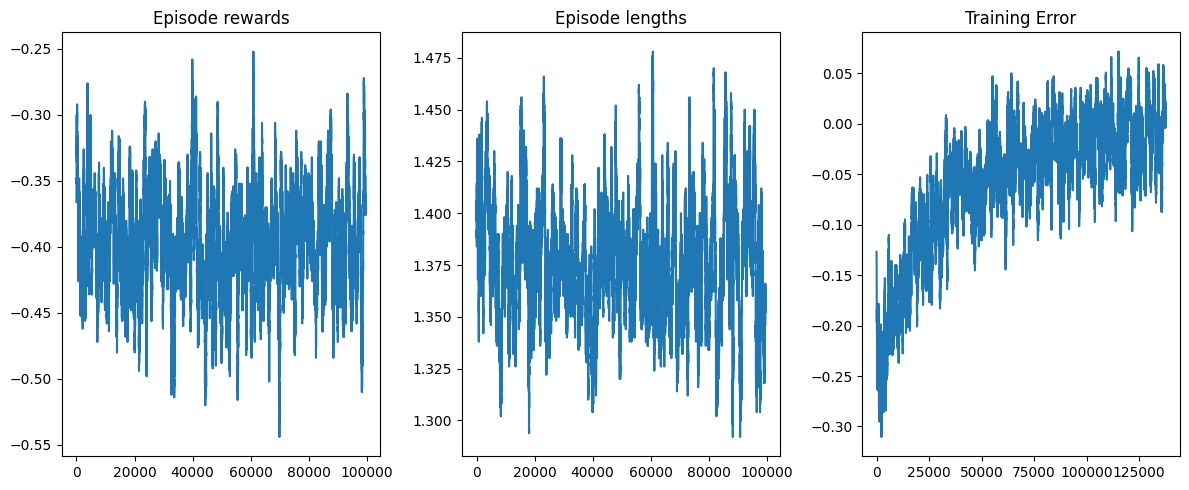

In [85]:
from matplotlib import pyplot as plt

def get_moving_avgs(arr, window, convolution_mode):
    return np.convolve(
        np.array(arr).flatten(),
        np.ones(window),
        mode=convolution_mode
    ) / window

# Smooth over a 500 episode window
rolling_length = 500
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))

axs[0].set_title("Episode rewards")
reward_moving_average = get_moving_avgs(
    env.return_queue,
    rolling_length,
    "valid"
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)

axs[1].set_title("Episode lengths")
length_moving_average = get_moving_avgs(
    env.length_queue,
    rolling_length,
    "valid"
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)

axs[2].set_title("Training Error")
training_error_moving_average = get_moving_avgs(
    agent.training_error,
    rolling_length,
    "same"
)
axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)
plt.tight_layout()
plt.show()